In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
import multiprocessing as mp

In [2]:
import sys
module_path = '/Users/junhaoxiong 1/Documents/Projects/mgcpy'
if module_path not in sys.path:
    sys.path.append(module_path)
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power import power
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
def compute_distance_matrix(data_matrix_X, data_matrix_Y):
    # obtain the pairwise distance matrix for X and Y
    dist_mtx_X = squareform(pdist(data_matrix_X, metric='euclidean'))
    dist_mtx_Y = squareform(pdist(data_matrix_Y, metric='euclidean'))
    return (dist_mtx_X, dist_mtx_Y)

## Power vs. Dimension

In [4]:
def power_vs_dimension(independence_test, simulation_type, dim_range, sim_name):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    estimated_power = np.zeros(dim_range)
    for d in range(1, dim_range+1):
        estimated_power[d-1] = power(independence_test, simulation_type, num_samples=100, num_dimensions=d, 
                                     simulation_type=sim_name)
    return estimated_power

In [5]:
def compute_all_power_vs_dimension(simulation_type, dim_range, sim_name):
    '''
    Compute power for each independence test for each dimension in a specified range 
    '''

    '''
    Initialize all independence test objects
    Data matrices initialized to np.nan, because in power computation each repeats involves generating new samples
    '''
    mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
    dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')
    mantel = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mantel')
    mgc = MGC(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    rv_corr = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    hhg = HHG(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    cca = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix, which_test='cca')
    
    
    independence_tests = {'MGC': mgc, 'MCorr': mcorr, 'DCorr': dcorr, 'Mantel': mantel,
                          'RV Corr': rv_corr, 'CCA': cca} #, 'HHG': hhg}
    power_results = {}
    
    
    # compute power for each test for each dimension
    for name, test in independence_tests.items():
        power = power_vs_dimension(test, simulation_type, dim_range, sim_name)
        power_results[name] = power
        print('{} finished'.format(name))
    
    #independence_tests = [mcorr, dcorr]
    #power_results = Parallel(n_jobs=2)(iter[delayed(power_vs_dimension)(test, simulation_type, dim_range) for test in independence_tests])
    
    
    return power_results

In [6]:
def find_dim_range(sim_name):
    dim_range = 0
    if sim_name in ['joint_normal', 'sine_4pi', 'sine_16pi', 'multi_noise']:
        dim_range = 10
    elif sim_name in ['step', 'spiral', 'circle', 'ellipse', 'quadratic', 'w_shape', 'two_parabolas', 'fourth_root']:
        dim_range = 20
    elif sim_name in ['multi_indept', 'bernoulli', 'log']:
        dim_range = 100
    else:
        dim_range = 40
    return dim_range

In [46]:
'''
simulations = {'joint_normal': joint_sim, 'sine_4pi': sin_sim, 'sine_16pi': sin_sim, 'multi_noise': multi_noise_sim,
               'step': step_sim, 'spiral': spiral_sim, 'circle': circle_sim, 'ellipse': circle_sim, 'diamond': square_sim,
               'log': log_sim, 'quadratic': quad_sim, 'w_shape': w_sim, 'two_parabolas': two_parab_sim, 'fourth_root': root_sim',
               multi_indept': multi_indep_sim, 'bernoulli': ubern_sim}
'''
simulations = {'bernoulli': ubern_sim}


for sim_name, sim_func in simulations.items():
    power_results = compute_all_power_vs_dimension(sim_func, find_dim_range(sim_name), sim_name)
    pickle.dump(power_results, open('../../NeuroData/power_curve_{}.pkl'.format(sim_name), 'wb'))
    print('{} finished'.format(sim_name))

MGC finished
MCorr finished
DCorr finished
Mantel finished
RV Corr finished
CCA finished
bernoulli finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_bernoulli.pkl'>
  if sys.path[0] == '':


## Power vs. Sample Size

In [7]:
pearson = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix, which_test='pearson')
power(pearson, linear_sim, num_samples=100, num_dimensions=1, noise=0)

corr [-0.07599475]
covar [0.45236342]
corr [1.]
covar 0.0
corr [-0.10658741]
covar [0.29120421]
corr [1.]
covar 0.0
corr [-0.06057066]
covar [0.54941203]
corr [1.]
covar 0.0
corr [0.01560276]
covar [0.87755037]
corr [1.]
covar 0.0
corr [-0.08206897]
covar [0.41693957]
corr [1.]
covar 0.0
corr [0.24106103]
covar [0.01569005]
corr [1.]
covar 0.0
corr [-0.0786711]
covar [0.43655311]
corr [1.]
covar 0.0
corr [0.14612936]
covar [0.14685746]
corr [1.]
covar 0.0
corr [-0.05877403]
covar [0.56133927]
corr [1.]
covar 0.0
corr [0.05831664]
covar [0.56439528]
corr [1.]
covar 0.0
corr [0.16691541]
covar [0.09694769]
corr [1.]
covar 0.0
corr [0.06184626]
covar [0.54101912]
corr [1.]
covar 0.0
corr [0.08529628]
covar [0.3987934]
corr [1.]
covar 0.0
corr [-0.02542063]
covar [0.8017748]
corr [1.]
covar 0.0
corr [0.16447756]
covar [0.10199578]
corr [1.]
covar 0.0
corr [-0.11272509]
covar [0.26414745]
corr [1.]
covar 0.0
corr [-0.00669646]
covar [0.9472796]
corr [1.]
covar 0.0
corr [0.1058228]
covar [0.

corr [0.09051295]
covar [0.37047181]
corr [1.]
covar 0.0
corr [0.13375622]
covar [0.18460268]
corr [1.]
covar 0.0
corr [-0.0219287]
covar [0.82855438]
corr [1.]
covar 0.0
corr [-0.145957]
covar [0.14733993]
corr [1.]
covar 0.0
corr [0.03210797]
covar [0.75114899]
corr [1.]
covar 0.0
corr [-0.03697299]
covar [0.71495734]
corr [1.]
covar 0.0
corr [-0.0169468]
covar [0.86709517]
corr [1.]
covar 0.0
corr [-0.01067996]
covar [0.91601091]
corr [1.]
covar 0.0
corr [0.08368456]
covar [0.40779638]
corr [1.]
covar 0.0
corr [0.01043194]
covar [0.91795454]
corr [1.]
covar 0.0
corr [-0.11744719]
covar [0.24453]
corr [1.]
covar 0.0
corr [0.11802402]
covar [0.24220452]
corr [1.]
covar 0.0
corr [0.05538985]
covar [0.58413476]
corr [1.]
covar 0.0
corr [-0.10268816]
covar [0.30931436]
corr [1.]
covar 0.0
corr [0.00194995]
covar [0.98463819]
corr [1.]
covar 0.0
corr [-0.02050636]
covar [0.83952059]
corr [1.]
covar 0.0
corr [0.15452428]
covar [0.12477132]
corr [1.]
covar 0.0
corr [-0.02295174]
covar [0.82

corr [1.]
covar 0.0
corr [0.10867959]
covar [0.28178238]
corr [1.]
covar 0.0
corr [-0.00670209]
covar [0.94723528]
corr [1.]
covar 0.0
corr [0.01030104]
covar [0.91898053]
corr [1.]
covar 0.0
corr [-0.03316833]
covar [0.74321154]
corr [1.]
covar 0.0
corr [-0.00771773]
covar [0.9392535]
corr [1.]
covar 0.0
corr [0.0154756]
covar [0.87854064]
corr [1.]
covar 0.0
corr [-0.00480528]
covar [0.96215547]
corr [1.]
covar 0.0
corr [0.07247159]
covar [0.4736534]
corr [1.]
covar 0.0
corr [-0.12017673]
covar [0.23366143]
corr [1.]
covar 0.0
corr [-0.01391403]
covar [0.89071652]
corr [1.]
covar 0.0
corr [-0.06390899]
covar [0.52758216]
corr [1.]
covar 0.0
corr [-0.02367259]
covar [0.81515392]
corr [1.]
covar 0.0
corr [-0.1437521]
covar [0.15361727]
corr [1.]
covar 0.0
corr [0.13144169]
covar [0.19238534]
corr [1.]
covar 0.0
corr [0.0327336]
covar [0.74646254]
corr [1.]
covar 0.0
corr [-0.00371202]
covar [0.97076121]
corr [1.]
covar 0.0
corr [-0.05982874]
covar [0.55432245]
corr [1.]
covar 0.0
corr 

covar [0.72682395]
corr [1.]
covar 0.0
corr [0.11525139]
covar [0.25352323]
corr [1.]
covar 0.0
corr [0.043053]
covar [0.67060748]
corr [1.]
covar 0.0
corr [0.00344191]
covar [0.97288797]
corr [1.]
covar 0.0
corr [0.12415554]
covar [0.2184298]
corr [1.]
covar 0.0
corr [-0.0964686]
covar [0.33968557]
corr [1.]
covar 0.0
corr [-0.00514156]
covar [0.95950916]
corr [1.]
covar 0.0
corr [-0.14166656]
covar [0.15973707]
corr [1.]
covar 0.0
corr [-0.04052193]
covar [0.68894355]
corr [1.]
covar 0.0
corr [0.06084951]
covar [0.54757197]
corr [1.]
covar 0.0
corr [-0.09222294]
covar [0.3614627]
corr [1.]
covar 0.0
corr [0.09739852]
covar [0.33502875]
corr [1.]
covar 0.0
corr [-0.09143572]
covar [0.36559327]
corr [1.]
covar 0.0
corr [0.12962199]
covar [0.19866881]
corr [1.]
covar 0.0
corr [0.09350066]
covar [0.35482011]
corr [1.]
covar 0.0
corr [-0.00303184]
covar [0.97611709]
corr [1.]
covar 0.0
corr [0.11020023]
covar [0.27506365]
corr [1.]
covar 0.0
corr [0.26096488]
covar [0.00873008]
corr [1.]


corr [0.06676532]
covar [0.50925631]
corr [1.]
covar 0.0
corr [0.11579487]
covar [0.2512765]
corr [1.]
covar 0.0
corr [-0.04781691]
covar [0.6366215]
corr [1.]
covar 0.0
corr [0.22870971]
covar [0.02209281]
corr [1.]
covar 0.0
corr [0.09848265]
covar [0.32965102]
corr [1.]
covar 0.0
corr [-0.17253463]
covar [0.08606096]
corr [1.]
covar 0.0
corr [-0.05750862]
covar [0.56981319]
corr [1.]
covar 0.0
corr [0.02477928]
covar [0.80667709]
corr [1.]
covar 0.0
corr [0.16507032]
covar [0.1007498]
corr [1.]
covar 0.0
corr [-0.01331842]
covar [0.89536744]
corr [1.]
covar 0.0
corr [0.04408776]
covar [0.66316574]
corr [1.]
covar 0.0
corr [0.12966396]
covar [0.19852224]
corr [1.]
covar 0.0
corr [-0.0769217]
covar [0.44685177]
corr [1.]
covar 0.0
corr [-0.09905922]
covar [0.32681355]
corr [1.]
covar 0.0
corr [-0.07148515]
covar [0.47971007]
corr [1.]
covar 0.0
corr [0.03328062]
covar [0.7423726]
corr [1.]
covar 0.0
corr [0.05757323]
covar [0.56937906]
corr [1.]
covar 0.0
corr [0.0453277]
covar [0.654

1.0

In [7]:
def power_vs_sample_size(independence_test, simulation_type, sim_name):
    '''
    Generate power of an independence test given a simulation for a range of sample size
    range is [5, 10, 15, ..., 95, 100]
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :return: power for each sample size
    '''
    sample_sizes = [i for i in range(5, 101, 5)]
    estimated_power = np.zeros(len(sample_sizes))
    
    for i, size in enumerate(sample_sizes):
        print('sample size: {}'.format(size))
        estimated_power[i] = power(independence_test, simulation_type, num_samples=size, num_dimensions=1, noise=1,
                                     simulation_type=sim_name)
    return estimated_power

In [8]:
def compute_all_power_vs_sample_size(simulation_type, sim_name):
    '''
    Compute power for each independence test for each dimension in a specified range 
    '''

    '''
    Initialize all independence test objects
    Data matrices initialized to np.nan, because in power computation each repeats involves generating new samples
    '''
    mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
    dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')
    mantel = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mantel')
    mgc = MGC(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    hhg = HHG(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    pearson = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix, which_test='pearson')
    
    
    independence_tests = {'Pearson': pearson} #{'MGC': mgc, 'MCorr': mcorr, 'DCorr': dcorr, 'Mantel': mantel,
                          #'Pearson': pearson} #, 'HHG': hhg}
    power_results = {}
    
    
    # compute power for each test for each dimension
    for name, test in independence_tests.items():
        power = power_vs_sample_size(test, simulation_type, sim_name)
        power_results[name] = power
        print('{} finished'.format(name))
    
    return power_results

In [12]:
#power_results = compute_all_power_vs_sample_size(ubern_sim, 'bernoulli')

sample size: 5
corr: [0.24067582]
covar: [0.69654668]
corr: [-0.59156146]
covar: [0.29338616]
corr: [-0.84143333]
covar: [0.07396778]
corr: [-0.88718008]
covar: [0.04471189]
corr: [0.21214416]
covar: [0.73192963]
corr: [-0.99907378]
covar: [3.38334327e-05]
corr: [0.47311238]
covar: [0.42090952]
corr: [0.69396969]
covar: [0.19362618]
corr: [0.17334204]
covar: [0.78040438]
corr: [0.99857536]
covar: [6.4535179e-05]
corr: [0.66261928]
covar: [0.22295237]
corr: [0.09343326]
covar: [0.8812104]
corr: [-0.29647509]
covar: [0.62812147]
corr: [-0.83777167]
covar: [0.07650025]
corr: [-0.02618638]
covar: [0.96666228]
corr: [0.11537928]
covar: [0.85342114]
corr: [0.25730281]
covar: [0.67604353]
corr: [-0.94192041]
covar: [0.01665517]
corr: [-0.36434235]
covar: [0.54658296]
corr: [-0.62304627]
covar: [0.261541]
corr: [0.20944583]
covar: [0.73528805]
corr: [-0.27739459]
covar: [0.65139354]
corr: [0.91671116]
covar: [0.02849132]
corr: [-0.40665035]
covar: [0.49688336]
corr: [0.84653556]
covar: [0.0704

TypeError: 'float' object is not subscriptable

In [9]:
simulations = {'bernoulli': ubern_sim, 'linear': linear_sim, 'exponential': exp_sim,
              'cubic': cub_sim, 'square': square_sim}
'''
{'joint_normal': joint_sim, 'sine_4pi': sin_sim, 'sine_16pi': sin_sim, 'multi_noise': multi_noise_sim,
               'step': step_sim, 'spiral': spiral_sim, 'circle': circle_sim, 'ellipse': circle_sim, 'diamond': square_sim,
               'log': log_sim, 'quadratic': quad_sim, 'w_shape': w_sim, 'two_parabolas': two_parab_sim, 'fourth_root': root_sim,
               'multi_indept': multi_indep_sim}
'''

for sim_name, sim_func in simulations.items():
    power_results = compute_all_power_vs_sample_size(sim_func, sim_name)
    pickle.dump(power_results, open('../../NeuroData/power_curve_sample_size_{}.pkl'.format(sim_name), 'wb'))
    print('{} finished'.format(sim_name))

MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
joint_normal finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_joint_normal.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
sine_4pi finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_sine_4pi.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
sine_16pi finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_sine_16pi.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
multi_noise finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_multi_noise.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
/Users/junhaoxiong 1/Documents/Projects/mgcpy/mgcpy/benchmarks/power.py:68: RuntimeWarning: invalid value encountered in greater_equal
  empirical_power = np.where(test_stats_alternative >= cutoff)[0].shape[0] / repeats


Pearson finished
step finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_step.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
spiral finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_spiral.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
circle finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_circle.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
ellipse finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_ellipse.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
diamond finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_diamond.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
log finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_log.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
quadratic finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_quadratic.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
w_shape finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_w_shape.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
two_parabolas finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_two_parabolas.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
fourth_root finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_fourth_root.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished
Pearson finished
multi_indept finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_sample_size_multi_indept.pkl'>
  if __name__ == '__main__':


MGC finished
MCorr finished
DCorr finished
Mantel finished


TypeError: 'float' object is not subscriptable

Error
* bernoulli: float not subscriptable
    * ~/Documents/Projects/mgcpy/mgcpy/independence_tests/rv_corr.py in test_statistic(self, data_matrix_X, data_matrix_Y)
     81         if (self.which_test == 'pearson') and ((row_X == 1 or columns_X == 1) and (row_Y == 1 or columns_Y == 1)):
     82             corr, covar = pearsonr(data_matrix_X, data_matrix_Y)
---> 83             corr, covar = corr[0], covar[0]
* step: power.py:68: RuntimeWarning: invalid value encountered in greater_equal
  empirical_power = np.where(test_stats_alternative >= cutoff)[0].shape[0] / repeats

In [52]:
power_results = pickle.load(open('../../NeuroData/power_curve_bernoulli.pkl', 'rb'))
#pickle.dump(power_results, open('../../NeuroData/power_curve_spiral.pkl', 'wb'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../../NeuroData/power_curve_bernoulli.pkl'>
  """Entry point for launching an IPython kernel.


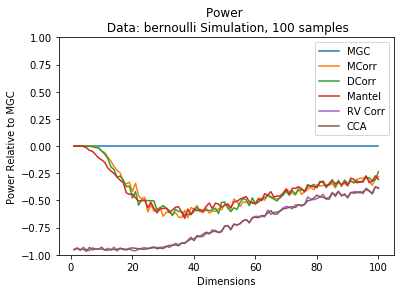

In [55]:
plot_power_curve_dimension(power_results, 'bernoulli')

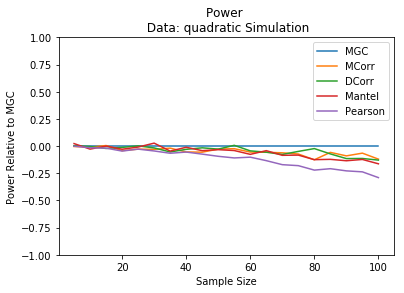

In [51]:
plot_power_curve_sample_size(power_results, 'quadratic')

## Plotting

In [54]:
def plot_power_curve_dimension(power_results, simulation_name):
    '''
    Plot the power of each independence test relative to mgc
    '''
    mgc_power = power_results['MGC']
    dimensions = np.arange(1, mgc_power.shape[0]+1)
    fig,ax = plt.subplots()

    for name, power in power_results.items():     
        ax.plot(dimensions, power-mgc_power, label=name)
    
    #ax.set_xticklabels([20])
    plt.xlabel('Dimensions')
    plt.ylabel('Power Relative to MGC')
    plt.legend()
    plt.gca().set_ylim(-1, 1)
    #plt.xticks(np.arange(1, mgc_power.shape[0]+1))
    plt.title('Power \n Data: {} Simulation, 100 samples'.format(simulation_name))
    #plt.show()

In [50]:
def plot_power_curve_sample_size(power_results, simulation_name):
    '''
    Plot the power of each independence test relative to mgc
    '''
    mgc_power = power_results['MGC']
    sample_sizes = [i for i in range(5, 101, 5)]
    fig,ax = plt.subplots()

    for name, power in power_results.items():     
        ax.plot(sample_sizes, power-mgc_power, label=name)
    
    #ax.set_xticklabels([20])
    plt.xlabel('Sample Size')
    plt.ylabel('Power Relative to MGC')
    plt.legend()
    plt.gca().set_ylim(-1, 1)
    #plt.xticks(np.arange(1, mgc_power.shape[0]+1))
    plt.title('Power \n Data: {} Simulation'.format(simulation_name))
    #plt.show()

In [22]:
def plot_all_curves(which_type):
    simulation_names = ['joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                        'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
    # 'bernoulli', 'square', 'linear', 'exponential', 'cubic', 
    
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12,12))  
    index = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[index]
            index += 1
            if which_type == 'dimension':
                if i == 0 and (j == 0 or j == 1 or j == 2):
                    col.set_ylim(-1, 1)
                    col.set_yticks([])
                    col.set_title(sim_name)
                    continue
                file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
            else:
                file = open('../../NeuroData/power_curve_sample_size_{}.pkl'.format(sim_name),  'rb')

            power_results = pickle.load(file)
            file.close()
            mgc_power = power_results['MGC']
            if which_type == 'dimension':
                x_axis = np.arange(1, mgc_power.shape[0]+1)
            else:
                x_axis = [i for i in range(5, 101, 5)]

            for name, power in power_results.items():
                col.plot(x_axis, power-mgc_power, label=name)
                col.set_ylim(-1, 1)
                col.set_yticks([])
                col.set_title(sim_name)
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    if which_type == 'dimension':
        fig.suptitle('Power Relative to MGC of Increasing Dimensions')
        plt.savefig('../../../../Desktop/Neuro Data Design/all_curves_dimensions')
    else:
        fig.suptitle('Power Relative to MGC of for 20 Simulated 1-Dimensional Settings')
        plt.savefig('../../../../Desktop/Neuro Data Design/all_curves_sample_size')

IndexError: list index out of range

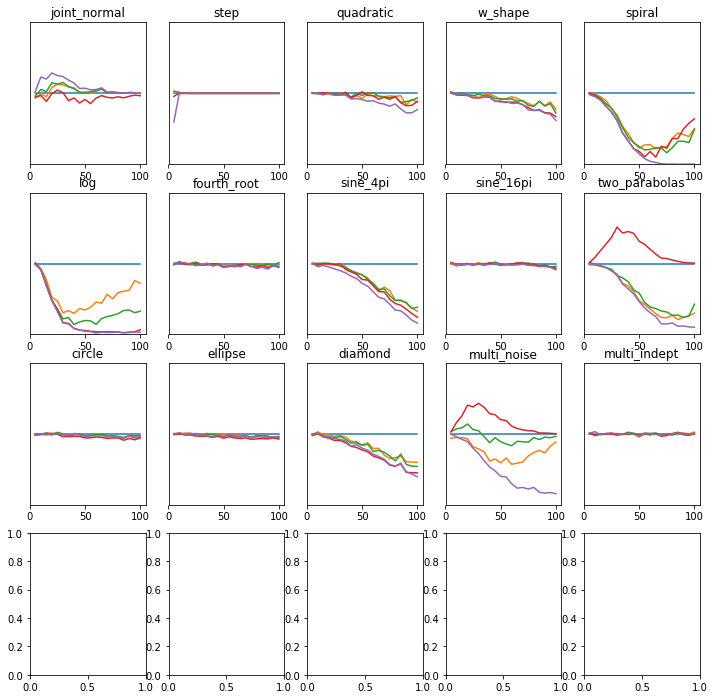

In [23]:
plot_all_curves('sample_size')

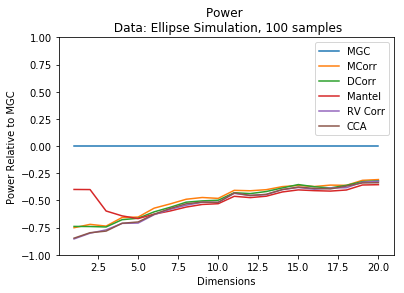

CPU times: user 135 ms, sys: 15.1 ms, total: 150 ms
Wall time: 149 ms


In [61]:
%%time
plot_power_curve(power_results, 'Ellipse')

## Results for simulations
* ones that got the correct power curve
    * quadratic, w shape, two parabolas, fourth root, joint normal, sine 16pi, independence, multiplicative (except for DCorr), log
* ones that are incorrect
    * step function, spiral, sine 4pi, circle, ellipse, diamond

## Parallel code

In [11]:
def power_vs_dimension_parallel(params_dict):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    print(params_dict['sim_name'], params_dict['independence_test'].get_name())
    estimated_power = np.zeros(params_dict['dim_range'])
    for d in range(1, params_dict['dim_range']+1):
        estimated_power[d-1] = power(params_dict['independence_test'], params_dict['simulation_type'], 
                                     num_samples=100, num_dimensions=d, 
                                     simulation_type=params_dict['sim_name'])
    print('finish')
    return (params_dict, estimated_power)

In [12]:
mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')

params_dict = [{'independence_test': mcorr, 'simulation_type': quad_sim, 'dim_range': 20, 'sim_name': 'quadratic'}, 
              {'independence_test': dcorr, 'simulation_type': quad_sim, 'dim_range': 20, 'sim_name': 'quadratic'}]

In [13]:
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

quadratic dcorr
quadratic mcorr
finish
finish


In [14]:
results

[({'dim_range': 20,
   'independence_test': <mgcpy.independence_tests.dcorr.DCorr at 0x1a15a836d8>,
   'sim_name': 'quadratic',
   'simulation_type': <function mgcpy.benchmarks.simulations.quad_sim>},
  array([1.   , 1.   , 1.   , 0.924, 0.682, 0.542, 0.353, 0.311, 0.233,
         0.21 , 0.19 , 0.13 , 0.152, 0.164, 0.128, 0.122, 0.104, 0.09 ,
         0.095, 0.093])),
 ({'dim_range': 20,
   'independence_test': <mgcpy.independence_tests.dcorr.DCorr at 0x1a15a835f8>,
   'sim_name': 'quadratic',
   'simulation_type': <function mgcpy.benchmarks.simulations.quad_sim>},
  array([1.   , 1.   , 1.   , 0.972, 0.8  , 0.633, 0.474, 0.392, 0.292,
         0.257, 0.226, 0.165, 0.193, 0.176, 0.161, 0.137, 0.14 , 0.115,
         0.126, 0.124]))]